# BigTable MTLM - dataset perplexity testing

Aim of this notebook:
1. Generate student + question datasets
2. Generate N sets of encounters
3. Report on agreement between these sets

The error between the datasets (for large N) is the inherent probabilistic error in the model
- How does this translate to tolerances in the $\alpha$ and $\delta$ parameters

## Model perplexity
A model $q$ is used to predict the values of a set of samples, $\mathbf{x}$.  Perplexity is defined as:

\\[{perplex}_{q}(\mathbf{x}) = b^{-\frac{1}{N}\Sigma_{i=1}^{N}{log_{b}(q(x_i))}}\\]

Perplexity is a measure of `surprise' as a divergence from the predictions that are seen in the true values.


In [101]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 2
min_active_traits = 2
max_active_traits = 2


In [102]:
generate_student_name()

'SIR RYS '

In [103]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/min_active_traits)
pr_k_hardest = q_p_hardest**(1/max_active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

# null_task_pr = 1/(1+exp(-baseline))
# print("null-task passrate", null_task_pr)
# print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**max_active_traits)
print("best Pr=", best_comp_pr**min_active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.744003674264945
th 2.5467790969287263 6.290782771193672
worst cmp chance= 0.10000000000000002
best cmp chance= 0.99498743710662
worst Pr= 0.010000000000000004
best Pr= 0.99
limits 0.8244480464246379 0.8244480464246379
[[1 2 3]
 [7 8 9]]
(2, 3)


In [104]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt, n_active):
        self.id = qix

        if n_active:
            if len(n_active)==2:
                min_active = n_active[0]
                max_active = n_active[1]
                n_c =  numpy.random.choice(range(min_active, max_active+1))
        else:
            n_c = nt

        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.betas[c] = random.uniform(min_diff, max_diff)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.thetas[c] = random.uniform(min_a, max_a)  


In [105]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [106]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [107]:
def create_qs_from_blobs(n_qs, n_clusters, nt=n_traits):
    from sklearn.datasets.samples_generator import make_blobs
    from sklearn.preprocessing import MinMaxScaler
    
    #beta_min,beta_max
    sc = MinMaxScaler(feature_range=(beta_min, beta_max))
    
    X, y = make_blobs(n_samples=n_qs, centers=n_clusters, n_features=nt, cluster_std=2, random_state=666)
#     baseline = numpy.min(X)
#     X = X - baseline
    X = sc.fit_transform(X)

    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()
    
    qns = []
    for qix, (blob, y) in enumerate(zip(X,y)):
        qn = Question(qix, 0,0, nt=nt, nnw=nnw)
        qn.betas = blob
        qn.group = y
        qns.append(qn)
        
    mags = []
    no_comps = []
    for q in qns:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
        
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    qn_table = BigTable((n_qs, nt),min_w=0, max_w=beta_max)    
    return qns, qn_table

In [108]:
def create_qs(n_qs, nt, active_limits):

    max_mag = sqrt((beta_max**2)*nt)
    min_mag = sqrt((beta_min**2)*nt)
    print("Vector length limits:",min_mag,max_mag)
    
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt, active_limits) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    return master_qs

In [109]:
def create_students(n_students, nt=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)
    
    itemz = array([ s.thetas for s in psi_list ])
#     fig.set_size_inches(10, 10)
    ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
    for i, txt in enumerate(itemz):
        ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
    plt.show()
    
    return psi_list

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [110]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
                while (not passed) and att<user_patience:
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, passed)
                    attempt_n_map[(q.id,psi.id)] += 1
                    attempts.append(tup)
                    print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                    attempts_by_psi[psi.name].append(tup)
                    attempts_by_q[q].append(tup)
                    att += 1
                if (not pass_to_remove) or (pass_to_remove and passed):
                    qs.remove(qix)
                print("len qs is", len(qs))
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

Vector length limits: 1.4142135623730951 6.70903433609328
Q:0, difficulty=5.15 across 2 components
Q:1, difficulty=3.89 across 2 components
Q:2, difficulty=5.07 across 2 components
Q:3, difficulty=3.95 across 2 components
Q:4, difficulty=4.73 across 2 components
Q:5, difficulty=5.49 across 2 components
Q:6, difficulty=4.82 across 2 components
Q:7, difficulty=4.82 across 2 components
Q:8, difficulty=3.91 across 2 components
Q:9, difficulty=5.53 across 2 components
Q:10, difficulty=4.45 across 2 components
Q:11, difficulty=3.22 across 2 components
Q:12, difficulty=5.08 across 2 components
Q:13, difficulty=3.64 across 2 components
Q:14, difficulty=5.29 across 2 components
Q:15, difficulty=3.94 across 2 components
Q:16, difficulty=4.27 across 2 components
Q:17, difficulty=4.02 across 2 components
Q:18, difficulty=3.36 across 2 components
Q:19, difficulty=2.14 across 2 components
Q:20, difficulty=3.87 across 2 components
Q:21, difficulty=5.88 across 2 components
Q:22, difficulty=6.02 across

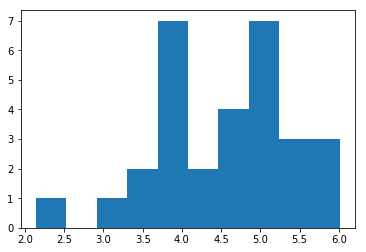

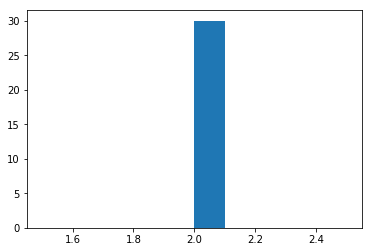

qid 0 [4.382045207550709, 2.7077136416742063]
qid 1 [2.874348169759296, 2.626303456145134]
qid 2 [4.037732889636235, 3.072956526466094]
qid 3 [1.461044451595881, 3.6663849490381155]
qid 4 [2.4432897289252216, 4.05046354314219]
qid 5 [4.338998651656148, 3.355390001024557]
qid 6 [4.7021375803577525, 1.0627688047436565]
qid 7 [1.3720800473515755, 4.622158567863759]
qid 8 [1.6356228676023141, 3.5517369077821197]
qid 9 [4.450694561513504, 3.285761569798471]
qid 10 [2.5727273151380805, 3.6302155639603364]
qid 11 [1.3233283595299397, 2.9358266260023225]
qid 12 [4.594682513406312, 2.16495695690213]
qid 13 [1.487592531168069, 3.3221811298581194]
qid 14 [4.374192113230391, 2.9787497024648903]
qid 15 [3.7598776002361176, 1.1903499320293132]
qid 16 [1.0522456405500955, 4.1332919133497406]
qid 17 [1.171746324398086, 3.8459835623304905]
qid 18 [1.9585963946199083, 2.7258814469267234]
qid 19 [1.1288556694421505, 1.814376494242242]
qid 20 [2.8756700368521875, 2.5957312624764413]
qid 21 [3.812877326665

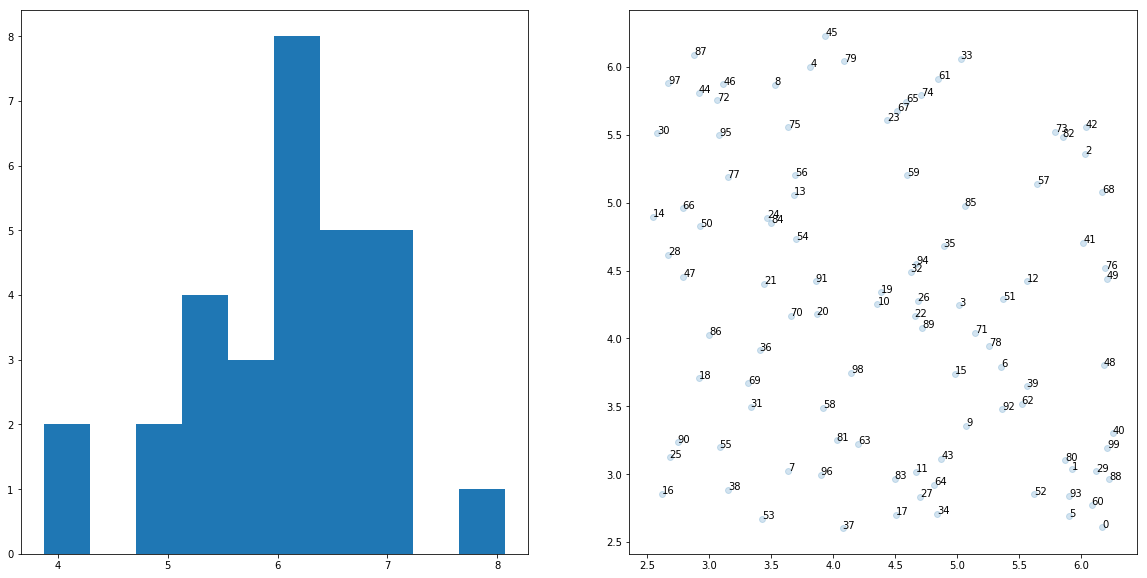

----0

p_pass was 0.7387951497237392 = 0
p_pass was 0.7387951497237392 = 1
len qs is 29
p_pass was 0.34520382135472427 = 1
len qs is 28
p_pass was 0.41638376927862175 = 1
len qs is 27
p_pass was 0.46406208354513295 = 1
len qs is 26
p_pass was 0.6845096720204794 = 0
p_pass was 0.6845096720204794 = 0
p_pass was 0.6845096720204794 = 1
len qs is 25
p_pass was 0.4854290015986004 = 0
p_pass was 0.4854290015986004 = 1
len qs is 24
p_pass was 0.277250505508438 = 1
len qs is 23
p_pass was 0.2858337455655953 = 0
p_pass was 0.2858337455655953 = 0
p_pass was 0.2858337455655953 = 1
len qs is 22
p_pass was 0.504781062438206 = 1
len qs is 21
p_pass was 0.21515576354172228 = 1
len qs is 20
p_pass was 0.3649985470429333 = 0
p_pass was 0.3649985470429333 = 0
p_pass was 0.3649985470429333 = 0
p_pass was 0.3649985470429333 = 0
p_pass was 0.3649985470429333 = 1
len qs is 19
p_pass was 0.1217000049918414 = 0
p_pass was 0.1217000049918414 = 0
p_pass was 0.1217000049918414 = 0
p_pass was 0.1217000049918414 = 

p_pass was 0.18502958192885427 = 0
p_pass was 0.18502958192885427 = 0
p_pass was 0.18502958192885427 = 1
len qs is 10
p_pass was 0.5598546245125868 = 1
len qs is 9
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 1
len qs is 8
p_pass was 0.2606452349297077 = 0
p_pass was 0.2606452349297077 = 0
p_pass was 0.2606452349297077 = 0
p_pass was 0.2606452349297077 = 0
p_pass was 0.2606452349297077 = 0
p_pass was 0.2606452349297077 = 1
len qs is 7
p_pass was 0.4429317995907817 = 0
p_pass was 0.4429317995907817 = 1
len qs is 6
p_pass was 0.21441767264213757 = 0
p_pass was 0.21441767264213757 = 0
p_pass was 0.21441767264213757 = 1
len qs is 5
p_pass was 0.8078451642040752 = 0
p_pass was 0.8078451642040752 = 0
p_pass was 0.8078451642040752 = 1
len qs is 4
p_pass was 0.3720971882567005 = 0
p_pass was 0.3720971882567005 = 0
p_pass was 0.3720971882567005 = 0
p_pass was 0.3720971882567005 = 0
p_pass was 0.372097188256

p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
len qs is 1
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
len qs is 1
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pass was 0.038130943020018744 = 0
p_pa

p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
len qs is 13
p_pass was 0.10387342625611705 = 1
len qs is 12
p_pass was 0.14387232210526907 = 0
p_pass was 0.14387232210526907 = 0
p_pass was 0.14387232210526907 = 0
p_pass was 0.14387232210526907 = 0
p_pass was 0.14387232210526907 = 1
len qs is 11
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
p_pass was 0.1364281307726816 = 0
len qs is 11
p_pass was 0.07085323513131318 = 0
p_pass was 0.07085323513131318 = 0
p_pass was 0.07085323513131318 = 0
p_pass was 0.07085323513131318 = 0
p_pass was 0.07085323513131318 = 0
p_pass was 0.070853

p_pass was 0.18681203470011915 = 0
p_pass was 0.18681203470011915 = 0
p_pass was 0.18681203470011915 = 1
len qs is 14
p_pass was 0.41901754007892655 = 1
len qs is 13
p_pass was 0.2589134077530189 = 0
p_pass was 0.2589134077530189 = 0
p_pass was 0.2589134077530189 = 1
len qs is 12
p_pass was 0.3709368601548308 = 0
p_pass was 0.3709368601548308 = 0
p_pass was 0.3709368601548308 = 0
p_pass was 0.3709368601548308 = 0
p_pass was 0.3709368601548308 = 1
len qs is 11
p_pass was 0.17495471577946903 = 0
p_pass was 0.17495471577946903 = 0
p_pass was 0.17495471577946903 = 1
len qs is 10
p_pass was 0.5615780946881558 = 1
len qs is 9
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 0
p_pass was 0.21546819813711618 = 1
len qs is 8
p_pass was 0.41113254123984355 = 0
p_pass was 0.41113254123984355 = 1
len qs is 

p_pass was 0.7346314274356601 = 1
len qs is 18
p_pass was 0.5944395714134192 = 0
p_pass was 0.5944395714134192 = 1
len qs is 17
p_pass was 0.7679308167396381 = 1
len qs is 16
p_pass was 0.7306734050180617 = 0
p_pass was 0.7306734050180617 = 1
len qs is 15
p_pass was 0.7497388089055624 = 1
len qs is 14
p_pass was 0.7110334192679922 = 0
p_pass was 0.7110334192679922 = 1
len qs is 13
p_pass was 0.8464521434746682 = 1
len qs is 12
p_pass was 0.7357390233822908 = 0
p_pass was 0.7357390233822908 = 1
len qs is 11
p_pass was 0.863522744548573 = 1
len qs is 10
p_pass was 0.8286422784431481 = 0
p_pass was 0.8286422784431481 = 1
len qs is 9
p_pass was 0.7994364144766304 = 1
len qs is 8
p_pass was 0.7465201045610423 = 0
p_pass was 0.7465201045610423 = 0
p_pass was 0.7465201045610423 = 1
len qs is 7
p_pass was 0.696726032471519 = 0
p_pass was 0.696726032471519 = 0
p_pass was 0.696726032471519 = 1
len qs is 6
p_pass was 0.6397981672975523 = 0
p_pass was 0.6397981672975523 = 1
len qs is 5
p_pass was 

p_pass was 0.38968095915566414 = 1
len qs is 6
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
p_pass was 0.14055528638665554 = 0
len qs is 6
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
len qs is 6
p_pass was 0.13381806339369048 = 1
len qs is 5
p_pass was 0.36345404102420475 = 0
p_pass was 0.36345404102420475 = 0
p_pass was 0.36345404102420475 = 0
p_pass was 0.36345404102420475 = 0
p_pass was 0.36345404102420475 = 1
len qs 

p_pass was 0.2897734598577747 = 0
p_pass was 0.2897734598577747 = 0
p_pass was 0.2897734598577747 = 1
len qs is 17
p_pass was 0.4371109583180437 = 1
len qs is 16
p_pass was 0.3055118627609067 = 0
p_pass was 0.3055118627609067 = 0
p_pass was 0.3055118627609067 = 0
p_pass was 0.3055118627609067 = 1
len qs is 15
p_pass was 0.45488699335890553 = 1
len qs is 14
p_pass was 0.4560876578504955 = 1
len qs is 13
p_pass was 0.5163458144574373 = 0
p_pass was 0.5163458144574373 = 1
len qs is 12
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
len qs is 12
p_pass was 0.7182720647216225 = 1
len qs is 11
p_pass was 0.5019911258123497 = 0
p_pass was 0.5019911258123497 = 1
len qs is 10
p_pass was 0.3978749330378297 = 

len qs is 26
p_pass was 0.8329755670476847 = 1
len qs is 25
p_pass was 0.9145754597756337 = 1
len qs is 24
p_pass was 0.467582899863965 = 0
p_pass was 0.467582899863965 = 1
len qs is 23
p_pass was 0.5613485551497899 = 1
len qs is 22
p_pass was 0.5433994056844947 = 1
len qs is 21
p_pass was 0.7133549974313785 = 1
len qs is 20
p_pass was 0.6365797999437934 = 1
len qs is 19
p_pass was 0.8865067967137277 = 1
len qs is 18
p_pass was 0.9549312124267536 = 1
len qs is 17
p_pass was 0.5550907306338928 = 1
len qs is 16
p_pass was 0.5143402633581353 = 0
p_pass was 0.5143402633581353 = 1
len qs is 15
p_pass was 0.8598280165736696 = 0
p_pass was 0.8598280165736696 = 1
len qs is 14
p_pass was 0.7706695364211013 = 1
len qs is 13
p_pass was 0.8271507449778632 = 1
len qs is 12
p_pass was 0.8187936508182843 = 1
len qs is 11
p_pass was 0.5494283444837857 = 0
p_pass was 0.5494283444837857 = 0
p_pass was 0.5494283444837857 = 1
len qs is 10
p_pass was 0.5368767514978501 = 1
len qs is 9
p_pass was 0.52116451

p_pass was 0.5617971113173581 = 0
p_pass was 0.5617971113173581 = 1
len qs is 13
p_pass was 0.8168673889117887 = 1
len qs is 12
p_pass was 0.822831077710435 = 1
len qs is 11
p_pass was 0.8646454099711536 = 1
len qs is 10
p_pass was 0.7669826130578117 = 1
len qs is 9
p_pass was 0.9410029168131993 = 1
len qs is 8
p_pass was 0.7810392544930599 = 1
len qs is 7
p_pass was 0.8109679494395345 = 1
len qs is 6
p_pass was 0.6679717191822228 = 1
len qs is 5
p_pass was 0.7329554238930269 = 1
len qs is 4
p_pass was 0.741235872224377 = 1
len qs is 3
p_pass was 0.5469257145020655 = 0
p_pass was 0.5469257145020655 = 0
p_pass was 0.5469257145020655 = 1
len qs is 2
p_pass was 0.5767347030256412 = 1
len qs is 1
p_pass was 0.6010038703274999 = 0
p_pass was 0.6010038703274999 = 1
len qs is 0
p_pass was 0.15150344733216858 = 0
p_pass was 0.15150344733216858 = 0
p_pass was 0.15150344733216858 = 1
len qs is 29
p_pass was 0.4914399245363888 = 1
len qs is 28
p_pass was 0.1468057470095175 = 0
p_pass was 0.146805

len qs is 8
p_pass was 0.5867893446587282 = 1
len qs is 7
p_pass was 0.4752702218296455 = 0
p_pass was 0.4752702218296455 = 0
p_pass was 0.4752702218296455 = 1
len qs is 6
p_pass was 0.3416403396885126 = 0
p_pass was 0.3416403396885126 = 0
p_pass was 0.3416403396885126 = 0
p_pass was 0.3416403396885126 = 0
p_pass was 0.3416403396885126 = 1
len qs is 5
p_pass was 0.47490924185784605 = 0
p_pass was 0.47490924185784605 = 1
len qs is 4
p_pass was 0.4468350784989824 = 0
p_pass was 0.4468350784989824 = 1
len qs is 3
p_pass was 0.5317382862093435 = 0
p_pass was 0.5317382862093435 = 1
len qs is 2
p_pass was 0.8073820729421097 = 1
len qs is 1
p_pass was 0.7483525228006173 = 1
len qs is 0
p_pass was 0.7461248425253556 = 1
len qs is 29
p_pass was 0.19795359185456304 = 0
p_pass was 0.19795359185456304 = 0
p_pass was 0.19795359185456304 = 0
p_pass was 0.19795359185456304 = 1
len qs is 28
p_pass was 0.5972561157267394 = 1
len qs is 27
p_pass was 0.5473878137644416 = 0
p_pass was 0.5473878137644416 =

p_pass was 0.768477088976247 = 1
len qs is 23
p_pass was 0.7780261217868694 = 1
len qs is 22
p_pass was 0.9005535519802482 = 0
p_pass was 0.9005535519802482 = 0
p_pass was 0.9005535519802482 = 1
len qs is 21
p_pass was 0.6368575421447988 = 1
len qs is 20
p_pass was 0.9647656312992906 = 1
len qs is 19
p_pass was 0.9021627280330856 = 1
len qs is 18
p_pass was 0.6272856896190118 = 1
len qs is 17
p_pass was 0.7757778596143452 = 1
len qs is 16
p_pass was 0.7832450610204159 = 1
len qs is 15
p_pass was 0.8132840121305891 = 0
p_pass was 0.8132840121305891 = 1
len qs is 14
p_pass was 0.8891252450526526 = 1
len qs is 13
p_pass was 0.8924841887434474 = 1
len qs is 12
p_pass was 0.7845596719838689 = 1
len qs is 11
p_pass was 0.8422207734475635 = 1
len qs is 10
p_pass was 0.8233652725583849 = 1
len qs is 9
p_pass was 0.6807775849997484 = 0
p_pass was 0.6807775849997484 = 1
len qs is 8
p_pass was 0.7439643009880558 = 1
len qs is 7
p_pass was 0.8753458662438243 = 1
len qs is 6
p_pass was 0.7987226750

p_pass was 0.578826517608059 = 0
p_pass was 0.578826517608059 = 1
len qs is 26
p_pass was 0.6776465635698464 = 0
p_pass was 0.6776465635698464 = 1
len qs is 25
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 1
len qs is 24
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 0
p_pass was 0.1584819994598264 = 1
len qs is 23
p_pass was 0.577505131374547 = 1
len qs is 22
p_pass was 0.1105778305937243 = 0
p_pass was 0.1105778305937243 = 0
p_pass was 0.1105778305937243 = 0
p_pass was 0.1105778305937243 = 1
len qs is 21
p_pass was 0.40183745014018507 = 0
p_pass was 0.40183745014018507 = 1
len qs is 20
p_pass was 0.5573262600242279 = 1
len qs is 19
p_pass was 0.12099802027022659 = 0
p_pass wa

p_pass was 0.2872059372210231 = 1
len qs is 23
p_pass was 0.5457453128335217 = 1
len qs is 22
p_pass was 0.49750057486357696 = 0
p_pass was 0.49750057486357696 = 1
len qs is 21
p_pass was 0.5013077313213942 = 0
p_pass was 0.5013077313213942 = 1
len qs is 20
p_pass was 0.6020668410426638 = 0
p_pass was 0.6020668410426638 = 1
len qs is 19
p_pass was 0.5737634724842474 = 1
len qs is 18
p_pass was 0.2895487132078516 = 0
p_pass was 0.2895487132078516 = 0
p_pass was 0.2895487132078516 = 0
p_pass was 0.2895487132078516 = 1
len qs is 17
p_pass was 0.2668822235045735 = 1
len qs is 16
p_pass was 0.8585453852536802 = 0
p_pass was 0.8585453852536802 = 1
len qs is 15
p_pass was 0.36242373699242547 = 1
len qs is 14
p_pass was 0.2539793214780836 = 0
p_pass was 0.2539793214780836 = 0
p_pass was 0.2539793214780836 = 0
p_pass was 0.2539793214780836 = 1
len qs is 13
p_pass was 0.6425563277749986 = 0
p_pass was 0.6425563277749986 = 1
len qs is 12
p_pass was 0.48262108395227504 = 0
p_pass was 0.48262108395

p_pass was 0.1254154167801994 = 0
p_pass was 0.1254154167801994 = 1
len qs is 3
p_pass was 0.10847973614187607 = 0
p_pass was 0.10847973614187607 = 1
len qs is 2
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
len qs is 2
p_pass was 0.3810345691415991 = 1
len qs is 1
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 0
p_pass was 0.12363278346217985 = 1
len qs is 0
p_pass was 0.5641225332109453 = 0
p_pass was 0.5641225332109453 = 0
p_pass was 0.5641225332109453 = 0
p_pass was 0.5641225332109453 = 1
len qs is 29
p_pass was 0.2838080202132033 = 1
len qs is 28
p_pass was 0

p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
len qs is 14
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 0
p_pass was 0.13250654893877956 = 1
len qs is 13
p_pass was 0.41431374004545163 = 0
p_pass was 0.41431374004545163 = 0
p_pass was 0.41431374004545163 = 0
p_pass was 0.41431374004545163 = 0
p_pass was 0.41431374004545163 = 0
p_pass was 0.41431374004545163 = 1
len qs is 12
p_pass was 0.2652049915389431 = 0
p_pass was 0.2652049915389431 = 0
p_pass was 0.2652049915389431 = 0
p_pass was 0.2652049915389431 = 0
p_pass was 0.2652049915389431 = 1
len qs is 11
p_pass was 0.057413045412582346 = 1
len qs is 10
p_pass was 0.0900404320438241

len qs is 12
p_pass was 0.24697495630678543 = 1
len qs is 11
p_pass was 0.661791232278389 = 1
len qs is 10
p_pass was 0.4518169008508135 = 0
p_pass was 0.4518169008508135 = 0
p_pass was 0.4518169008508135 = 0
p_pass was 0.4518169008508135 = 1
len qs is 9
p_pass was 0.15974351504118547 = 0
p_pass was 0.15974351504118547 = 0
p_pass was 0.15974351504118547 = 0
p_pass was 0.15974351504118547 = 1
len qs is 8
p_pass was 0.16937686142693315 = 0
p_pass was 0.16937686142693315 = 1
len qs is 7
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
p_pass was 0.14529436577789923 = 0
len qs is 7
p_pass was 0.1487854952746024 = 0
p_pass was 0.1487854952746024 = 0
p_pass was 0.1487854952746024 = 0
p_pass was 0.1487854952746024 = 0
p_pass was 0.

len qs is 7
p_pass was 0.2897734598577747 = 1
len qs is 6
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
p_pass was 0.13504714848672603 = 0
len qs is 6
p_pass was 0.36296169680346724 = 1
len qs is 5
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 1
len qs is 4
p_pass was 0.13504714848672603 = 1
len qs is 3
p_pass was 0.7182720647216225 = 1
len qs is 2
p_pass was 0.38042738939473536 = 1
len qs is 1
p_pass was 0.5019911258123497 = 0
p_pass was 0.5019911258123497 = 1
len qs is 0
p_pass was 0.5958771748072764 = 1
len qs is 29
p_pass was 0.7487206265545583 = 1
len qs is 28
p_pass was 0.9242586910537356 = 1
len qs is 27
p_pass was 0.59509605730999 = 1
len qs is 26
p_pass was 0.

p_pass was 0.1734363329102705 = 0
p_pass was 0.1734363329102705 = 0
p_pass was 0.1734363329102705 = 0
p_pass was 0.1734363329102705 = 0
p_pass was 0.1734363329102705 = 0
p_pass was 0.1734363329102705 = 1
len qs is 2
p_pass was 0.19462013441949258 = 1
len qs is 1
p_pass was 0.36448291371895014 = 0
p_pass was 0.36448291371895014 = 0
p_pass was 0.36448291371895014 = 1
len qs is 0
p_pass was 0.3510916317956884 = 1
len qs is 29
p_pass was 0.33360276124347016 = 0
p_pass was 0.33360276124347016 = 1
len qs is 28
p_pass was 0.7574184497139702 = 1
len qs is 27
p_pass was 0.3100957059524347 = 0
p_pass was 0.3100957059524347 = 1
len qs is 26
p_pass was 0.6024137134723588 = 0
p_pass was 0.6024137134723588 = 1
len qs is 25
p_pass was 0.539435872727387 = 0
p_pass was 0.539435872727387 = 0
p_pass was 0.539435872727387 = 1
len qs is 24
p_pass was 0.5389929568863618 = 0
p_pass was 0.5389929568863618 = 0
p_pass was 0.5389929568863618 = 0
p_pass was 0.5389929568863618 = 1
len qs is 23
p_pass was 0.6333668

p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
len qs is 4
p_pass was 0.39274815699132476 = 1
len qs is 3
p_pass was 0.32811854459419776 = 0
p_pass was 0.32811854459419776 = 1
len qs is 2
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 0
p_pass was 0.11318572580251031 = 1
len qs is 1
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
len qs is 1
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593 = 0
p_pass was 0.22408470382106593

len qs is 5
p_pass was 0.4934289989149744 = 1
len qs is 4
p_pass was 0.6533289055875916 = 1
len qs is 3
p_pass was 0.2175951336115347 = 0
p_pass was 0.2175951336115347 = 0
p_pass was 0.2175951336115347 = 0
p_pass was 0.2175951336115347 = 0
p_pass was 0.2175951336115347 = 0
p_pass was 0.2175951336115347 = 0
p_pass was 0.2175951336115347 = 1
len qs is 2
p_pass was 0.5283630876741772 = 1
len qs is 1
p_pass was 0.3906793728145981 = 0
p_pass was 0.3906793728145981 = 0
p_pass was 0.3906793728145981 = 1
len qs is 0
p_pass was 0.517638204507381 = 0
p_pass was 0.517638204507381 = 0
p_pass was 0.517638204507381 = 1
len qs is 29
p_pass was 0.534044308055865 = 0
p_pass was 0.534044308055865 = 1
len qs is 28
p_pass was 0.21306897110859482 = 0
p_pass was 0.21306897110859482 = 0
p_pass was 0.21306897110859482 = 0
p_pass was 0.21306897110859482 = 0
p_pass was 0.21306897110859482 = 0
p_pass was 0.21306897110859482 = 1
len qs is 27
p_pass was 0.40275785940103187 = 0
p_pass was 0.40275785940103187 = 1
le

p_pass was 0.17037131171986317 = 0
p_pass was 0.17037131171986317 = 0
p_pass was 0.17037131171986317 = 0
p_pass was 0.17037131171986317 = 1
len qs is 5
p_pass was 0.4782977984168898 = 0
p_pass was 0.4782977984168898 = 0
p_pass was 0.4782977984168898 = 0
p_pass was 0.4782977984168898 = 0
p_pass was 0.4782977984168898 = 1
len qs is 4
p_pass was 0.42368541540946913 = 1
len qs is 3
p_pass was 0.6775241578291639 = 0
p_pass was 0.6775241578291639 = 0
p_pass was 0.6775241578291639 = 1
len qs is 2
p_pass was 0.7657112023979017 = 1
len qs is 1
p_pass was 0.3683961436975251 = 0
p_pass was 0.3683961436975251 = 0
p_pass was 0.3683961436975251 = 0
p_pass was 0.3683961436975251 = 0
p_pass was 0.3683961436975251 = 1
len qs is 0
p_pass was 0.8422207734475635 = 1
len qs is 29
p_pass was 0.7757778596143452 = 0
p_pass was 0.7757778596143452 = 1
len qs is 28
p_pass was 0.8359769019584156 = 1
len qs is 27
p_pass was 0.9173438996227786 = 0
p_pass was 0.9173438996227786 = 1
len qs is 26
p_pass was 0.68077758

p_pass was 0.3808286150246435 = 0
p_pass was 0.3808286150246435 = 0
p_pass was 0.3808286150246435 = 0
p_pass was 0.3808286150246435 = 0
p_pass was 0.3808286150246435 = 0
p_pass was 0.3808286150246435 = 0
p_pass was 0.3808286150246435 = 1
len qs is 12
p_pass was 0.22398277921679824 = 0
p_pass was 0.22398277921679824 = 0
p_pass was 0.22398277921679824 = 1
len qs is 11
p_pass was 0.11608652883818268 = 0
p_pass was 0.11608652883818268 = 1
len qs is 10
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 0
p_pass was 0.11781120685574488 = 1
len qs is 9
p_pass was 0.10745917191997358 = 0
p_pass was 0.10745917191997358 = 1
len qs is 8
p_pass was 0.12679371024179156 = 0
p_pass was 0.12679371024179156 = 0
p_pass was 0.12679371024179156 = 0
p_pass was 0.12679371024179156 = 1
len qs is 7
p_pass was 0.13263518513532688 = 0
p_pass was 0.132635185

p_pass was 0.48246068048468066 = 1
len qs is 17
p_pass was 0.42950877566690165 = 0
p_pass was 0.42950877566690165 = 1
len qs is 16
p_pass was 0.33310991059135514 = 0
p_pass was 0.33310991059135514 = 1
len qs is 15
p_pass was 0.7256782387597347 = 0
p_pass was 0.7256782387597347 = 1
len qs is 14
p_pass was 0.8466053219231265 = 1
len qs is 13
p_pass was 0.519568534897402 = 1
len qs is 12
p_pass was 0.2815383001591208 = 0
p_pass was 0.2815383001591208 = 1
len qs is 11
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
p_pass was 0.21489520004206492 = 0
len qs is 11
p_pass was 0.5764251519741496 = 0
p_pass was 0.5764251519741496 = 0
p_pass was 0.5764251519741496 = 1
len qs is 10
p_pass was 0.5509077910717158 = 0
p_pass was 0.550907

p_pass was 0.13644138822354004 = 0
len qs is 11
p_pass was 0.5459424741917346 = 1
len qs is 10
p_pass was 0.7596126786356128 = 1
len qs is 9
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 0
p_pass was 0.13644138822354004 = 1
len qs is 8
p_pass was 0.4695400383086908 = 1
len qs is 7
p_pass was 0.16383331914739407 = 0
p_pass was 0.16383331914739407 = 1
len qs is 6
p_pass was 0.3596809360299064 = 0
p_pass was 0.3596809360299064 = 0
p_pass was 0.3596809360299064 = 0
p_pass was 0.3596809360299064 = 1
len qs is 5
p_pass was 0.21546819813711618 = 1
len qs is 4
p_pass was 0.17872630912654897 = 0
p_pass was 0.17872630912654897 = 0
p_pass was 0.17872630912654897 = 0
p_pass was 0.17872630912654897 = 0
p_pass was 0.17872630912654897 = 0
p_pass was 0.17872630912654897 = 0
p_pass was 0.17872630912654897 = 1

p_pass was 0.5028342722812954 = 0
p_pass was 0.5028342722812954 = 0
p_pass was 0.5028342722812954 = 1
len qs is 20
p_pass was 0.43228829550528935 = 0
p_pass was 0.43228829550528935 = 0
p_pass was 0.43228829550528935 = 0
p_pass was 0.43228829550528935 = 0
p_pass was 0.43228829550528935 = 1
len qs is 19
p_pass was 0.19594808782509945 = 0
p_pass was 0.19594808782509945 = 0
p_pass was 0.19594808782509945 = 1
len qs is 18
p_pass was 0.6357386058288124 = 0
p_pass was 0.6357386058288124 = 1
len qs is 17
p_pass was 0.36451727854647487 = 1
len qs is 16
p_pass was 0.5775175586353775 = 1
len qs is 15
p_pass was 0.5499173646836163 = 0
p_pass was 0.5499173646836163 = 0
p_pass was 0.5499173646836163 = 1
len qs is 14
p_pass was 0.5229680257584564 = 0
p_pass was 0.5229680257584564 = 0
p_pass was 0.5229680257584564 = 0
p_pass was 0.5229680257584564 = 1
len qs is 13
p_pass was 0.49026293008389543 = 1
len qs is 12
p_pass was 0.217941728120222 = 0
p_pass was 0.217941728120222 = 0
p_pass was 0.217941728120

p_pass was 0.7097098991270051 = 1
len qs is 0
p_pass was 0.41526046923657867 = 0
p_pass was 0.41526046923657867 = 0
p_pass was 0.41526046923657867 = 0
p_pass was 0.41526046923657867 = 0
p_pass was 0.41526046923657867 = 0
p_pass was 0.41526046923657867 = 1
len qs is 29
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 0
p_pass was 0.14331170039421484 = 1
len qs is 28
p_pass was 0.38968095915566414 = 0
p_pass was 0.38968095915566414 = 1
len qs is 27
p_pass was 0.5223246526571248 = 1
len qs is 26
p_pass was 0.32552463054229214 = 0
p_pass was 0.32552463054229214 = 0
p_pass was 0.32552463054229214 = 1
len qs is 25
p_pass was 0.517854857792597 = 0
p_pass was 0.517854857792597 = 0
p_pass was 0.517854857792597 = 1
len qs is 24
p_pass was 0.48944930437653944 = 1
len qs is 23
p_pass was 0.7271007979770497 

p_pass was 0.3055118627609067 = 0
p_pass was 0.3055118627609067 = 0
p_pass was 0.3055118627609067 = 1
len qs is 16
p_pass was 0.28808760317104737 = 0
p_pass was 0.28808760317104737 = 1
len qs is 15
p_pass was 0.13504714848672603 = 1
len qs is 14
p_pass was 0.31147690841465536 = 0
p_pass was 0.31147690841465536 = 1
len qs is 13
p_pass was 0.5042361452206952 = 0
p_pass was 0.5042361452206952 = 1
len qs is 12
p_pass was 0.38042738939473536 = 0
p_pass was 0.38042738939473536 = 0
p_pass was 0.38042738939473536 = 1
len qs is 11
p_pass was 0.5236153265803912 = 0
p_pass was 0.5236153265803912 = 0
p_pass was 0.5236153265803912 = 1
len qs is 10
p_pass was 0.5019911258123497 = 1
len qs is 9
p_pass was 0.4282162618843777 = 0
p_pass was 0.4282162618843777 = 1
len qs is 8
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.1405155544063538 = 0
p_pass was 0.14051555440635

p_pass was 0.6282959934912349 = 0
p_pass was 0.6282959934912349 = 0
p_pass was 0.6282959934912349 = 0
p_pass was 0.6282959934912349 = 1
len qs is 23
p_pass was 0.28847927027320125 = 1
len qs is 22
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 0
p_pass was 0.2540393255669939 = 1
len qs is 21
p_pass was 0.41156642609164806 = 1
len qs is 20
p_pass was 0.6479023587173809 = 1
len qs is 19
p_pass was 0.46413878336890885 = 0
p_pass was 0.46413878336890885 = 0
p_pass was 0.46413878336890885 = 1
len qs is 18
p_pass was 0.2988699552719569 = 0
p_pass was 0.2988699552719569 = 0
p_pass was 0.2988699552719569 = 0
p_pass was 0.2988699552719569 = 1
len qs is 17
p_pass was 0.6388800199859264 = 1
len qs is 16
p_pass was 0.31070955198217626 = 1
len qs

p_pass was 0.24660661165933384 = 1
len qs is 24
p_pass was 0.3621115200245508 = 1
len qs is 23
p_pass was 0.6803150908098562 = 1
len qs is 22
p_pass was 0.23065290072466232 = 0
p_pass was 0.23065290072466232 = 1
len qs is 21
p_pass was 0.4246299985459141 = 0
p_pass was 0.4246299985459141 = 0
p_pass was 0.4246299985459141 = 1
len qs is 20
p_pass was 0.7249738329296315 = 1
len qs is 19
p_pass was 0.6186089942091185 = 1
len qs is 18
p_pass was 0.49770271994348503 = 1
len qs is 17
p_pass was 0.26214191094116235 = 0
p_pass was 0.26214191094116235 = 1
len qs is 16
p_pass was 0.24903151643513452 = 1
len qs is 15
p_pass was 0.7828531647709382 = 1
len qs is 14
p_pass was 0.6776113428059669 = 1
len qs is 13
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 0
p_pass was 0.2552581620589952 = 1
len qs is 12
p_pass w

p_pass was 0.4707013503543961 = 0
p_pass was 0.4707013503543961 = 1
len qs is 4
p_pass was 0.4973825326415935 = 0
p_pass was 0.4973825326415935 = 0
p_pass was 0.4973825326415935 = 0
p_pass was 0.4973825326415935 = 1
len qs is 3
p_pass was 0.3906793728145981 = 1
len qs is 2
p_pass was 0.34259738415313334 = 0
p_pass was 0.34259738415313334 = 1
len qs is 1
p_pass was 0.47424698762659767 = 1
len qs is 0
p_pass was 0.7502796658212378 = 0
p_pass was 0.7502796658212378 = 1
len qs is 29
p_pass was 0.517638204507381 = 0
p_pass was 0.517638204507381 = 1
len qs is 28
p_pass was 0.40275785940103187 = 0
p_pass was 0.40275785940103187 = 1
len qs is 27
p_pass was 0.6569743515335713 = 1
len qs is 26
p_pass was 0.5051966953952247 = 1
len qs is 25
p_pass was 0.2647813821460408 = 0
p_pass was 0.2647813821460408 = 1
len qs is 24
p_pass was 0.14455111555123254 = 0
p_pass was 0.14455111555123254 = 1
len qs is 23
p_pass was 0.7292565000400846 = 1
len qs is 22
p_pass was 0.520913812671455 = 0
p_pass was 0.520

p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
p_pass was 0.34323187593806886 = 0
len qs is 19
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
len qs is 19
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
p_pass was 0.2755916730781887 = 0
len qs is 19
p

p_pass was 0.40886444549075246 = 0
p_pass was 0.40886444549075246 = 0
p_pass was 0.40886444549075246 = 0
p_pass was 0.40886444549075246 = 1
len qs is 20
p_pass was 0.2991133322300884 = 0
p_pass was 0.2991133322300884 = 0
p_pass was 0.2991133322300884 = 1
len qs is 19
p_pass was 0.3078507323763397 = 0
p_pass was 0.3078507323763397 = 0
p_pass was 0.3078507323763397 = 0
p_pass was 0.3078507323763397 = 0
p_pass was 0.3078507323763397 = 1
len qs is 18
p_pass was 0.8159764479529671 = 1
len qs is 17
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 0
p_pass was 0.28781967181005136 = 1
len qs is 16
p_pass was 0.6065364550605139 = 1
len qs is 15
p_pass was 0.47031969056916034 = 0
p_pass was 0.47031969056916034 = 1
len qs is 14
p_pass was 0.713018838283862 = 1
len qs is 13
p_pass was 0.7226601730914554 = 1

p_pass was 0.5457453128335217 = 1
len qs is 10
p_pass was 0.5013077313213942 = 0
p_pass was 0.5013077313213942 = 0
p_pass was 0.5013077313213942 = 1
len qs is 9
p_pass was 0.345331002619629 = 0
p_pass was 0.345331002619629 = 1
len qs is 8
p_pass was 0.20174856840826264 = 0
p_pass was 0.20174856840826264 = 1
len qs is 7
p_pass was 0.6050324875563512 = 0
p_pass was 0.6050324875563512 = 1
len qs is 6
p_pass was 0.19648453918046543 = 0
p_pass was 0.19648453918046543 = 0
p_pass was 0.19648453918046543 = 0
p_pass was 0.19648453918046543 = 0
p_pass was 0.19648453918046543 = 0
p_pass was 0.19648453918046543 = 0
p_pass was 0.19648453918046543 = 1
len qs is 5
p_pass was 0.6020668410426638 = 0
p_pass was 0.6020668410426638 = 0
p_pass was 0.6020668410426638 = 0
p_pass was 0.6020668410426638 = 1
len qs is 4
p_pass was 0.2872059372210231 = 0
p_pass was 0.2872059372210231 = 0
p_pass was 0.2872059372210231 = 0
p_pass was 0.2872059372210231 = 0
p_pass was 0.2872059372210231 = 1
len qs is 3
p_pass was 0

len qs is 6
p_pass was 0.36499013553211473 = 0
p_pass was 0.36499013553211473 = 1
len qs is 5
p_pass was 0.5641225332109453 = 1
len qs is 4
p_pass was 0.45385473790227426 = 1
len qs is 3
p_pass was 0.17253116739149998 = 0
p_pass was 0.17253116739149998 = 0
p_pass was 0.17253116739149998 = 0
p_pass was 0.17253116739149998 = 0
p_pass was 0.17253116739149998 = 1
len qs is 2
p_pass was 0.35665887798459994 = 1
len qs is 1
p_pass was 0.7642656960015336 = 1
len qs is 0
p_pass was 0.16678216771482463 = 0
p_pass was 0.16678216771482463 = 1
len qs is 29
p_pass was 0.6740757282122254 = 1
len qs is 28
p_pass was 0.6515538675363608 = 0
p_pass was 0.6515538675363608 = 0
p_pass was 0.6515538675363608 = 1
len qs is 27
p_pass was 0.6317553709298762 = 1
len qs is 26
p_pass was 0.10611411501441408 = 0
p_pass was 0.10611411501441408 = 0
p_pass was 0.10611411501441408 = 0
p_pass was 0.10611411501441408 = 0
p_pass was 0.10611411501441408 = 0
p_pass was 0.10611411501441408 = 0
p_pass was 0.10611411501441408 

p_pass was 0.30417057038985057 = 0
p_pass was 0.30417057038985057 = 0
p_pass was 0.30417057038985057 = 0
p_pass was 0.30417057038985057 = 0
p_pass was 0.30417057038985057 = 1
len qs is 12
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
p_pass was 0.06907882534030221 = 0
len qs is 12
p_pass was 0.39195805195057204 = 0
p_pass was 0.39195805195057204 = 0
p_pass was 0.39195805195057204 = 0
p_pass was 0.39195805195057204 = 1
len qs is 11
p_pass was 0.2042019520685645 = 1
len qs is 10
p_pass was 0.06907882534030221 = 1
len qs is 9
p_pass was 0.07475868976619594 = 0
p_pass was 0.07475868976619594 = 0
p_pass was 0.07475868976619594 = 0
p_pass was 0.07475868976619594 = 0
p_pass was 0.07475868976619594 = 0
p_pass was 0.07475868976619

p_pass was 0.12487358904212656 = 0
p_pass was 0.12487358904212656 = 0
p_pass was 0.12487358904212656 = 0
p_pass was 0.12487358904212656 = 0
p_pass was 0.12487358904212656 = 0
p_pass was 0.12487358904212656 = 0
len qs is 24
p_pass was 0.541223231359686 = 1
len qs is 23
p_pass was 0.38559559535920196 = 0
p_pass was 0.38559559535920196 = 0
p_pass was 0.38559559535920196 = 1
len qs is 22
p_pass was 0.12860690903777974 = 0
p_pass was 0.12860690903777974 = 0
p_pass was 0.12860690903777974 = 0
p_pass was 0.12860690903777974 = 1
len qs is 21
p_pass was 0.5405570774221915 = 1
len qs is 20
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
p_pass was 0.17869011277439734 = 0
len qs is 20
p_pass was 0.5920817731333785 = 1
len qs is 19
p_p

p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
len qs is 3
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
p_pass was 0.07051431639572066 = 0
len qs is 3
p_pass was 0.33885202468520537 = 1
len qs is 2
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
p_pass was 0.061240242781430025 = 0
len

p_pass was 0.9474423715393777 = 1
len qs is 18
p_pass was 0.8327061823635318 = 1
len qs is 17
p_pass was 0.5075695372047967 = 0
p_pass was 0.5075695372047967 = 1
len qs is 16
p_pass was 0.8460398543240405 = 1
len qs is 15
p_pass was 0.49572197454802497 = 0
p_pass was 0.49572197454802497 = 1
len qs is 14
p_pass was 0.4891374181605897 = 1
len qs is 13
p_pass was 0.8423984035099694 = 1
len qs is 12
p_pass was 0.5018107829365881 = 1
len qs is 11
p_pass was 0.8713027795433804 = 1
len qs is 10
p_pass was 0.8073160607295641 = 1
len qs is 9
p_pass was 0.7748623625224279 = 1
len qs is 8
p_pass was 0.6980486363501524 = 1
len qs is 7
p_pass was 0.5137231047125737 = 1
len qs is 6
p_pass was 0.5919593924451877 = 1
len qs is 5
p_pass was 0.4493014710592037 = 1
len qs is 4
p_pass was 0.575010894456828 = 1
len qs is 3
p_pass was 0.7425258746645065 = 0
p_pass was 0.7425258746645065 = 1
len qs is 2
p_pass was 0.6193018559579685 = 0
p_pass was 0.6193018559579685 = 0
p_pass was 0.6193018559579685 = 1
len 

p_pass was 0.4394600342603261 = 1
len qs is 14
p_pass was 0.5872089270604801 = 1
len qs is 13
p_pass was 0.2605457961452566 = 0
p_pass was 0.2605457961452566 = 0
p_pass was 0.2605457961452566 = 0
p_pass was 0.2605457961452566 = 0
p_pass was 0.2605457961452566 = 0
p_pass was 0.2605457961452566 = 0
p_pass was 0.2605457961452566 = 1
len qs is 12
p_pass was 0.2846151964350519 = 1
len qs is 11
p_pass was 0.3656987579291752 = 0
p_pass was 0.3656987579291752 = 0
p_pass was 0.3656987579291752 = 1
len qs is 10
p_pass was 0.48729056827224126 = 1
len qs is 9
p_pass was 0.17811046113534212 = 0
p_pass was 0.17811046113534212 = 0
p_pass was 0.17811046113534212 = 0
p_pass was 0.17811046113534212 = 0
p_pass was 0.17811046113534212 = 0
p_pass was 0.17811046113534212 = 1
len qs is 8
p_pass was 0.4372067824514346 = 0
p_pass was 0.4372067824514346 = 1
len qs is 7
p_pass was 0.594031248558895 = 0
p_pass was 0.594031248558895 = 1
len qs is 6
p_pass was 0.535544275512339 = 0
p_pass was 0.535544275512339 = 0


p_pass was 0.10136489235232615 = 0
p_pass was 0.10136489235232615 = 0
p_pass was 0.10136489235232615 = 0
p_pass was 0.10136489235232615 = 0
p_pass was 0.10136489235232615 = 0
p_pass was 0.10136489235232615 = 0
p_pass was 0.10136489235232615 = 1
len qs is 25
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
p_pass was 0.09980187781218164 = 0
len qs is 25
p_pass was 0.29549916502429313 = 1
len qs is 24
p_pass was 0.17639538738281335 = 1
len qs is 23
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_pass was 0.15841476683342468 = 0
p_p

p_pass was 0.6534026032266308 = 1
len qs is 9
p_pass was 0.262249467834331 = 1
len qs is 8
p_pass was 0.3691451527088319 = 0
p_pass was 0.3691451527088319 = 0
p_pass was 0.3691451527088319 = 0
p_pass was 0.3691451527088319 = 1
len qs is 7
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 0
p_pass was 0.3026576469899047 = 1
len qs is 6
p_pass was 0.3272269147436264 = 0
p_pass was 0.3272269147436264 = 1
len qs is 5
p_pass was 0.5649304087992226 = 1
len qs is 4
p_pass was 0.35914056009055 = 0
p_pass was 0.35914056009055 = 0
p_pass was 0.35914056009055 = 1
len qs is 3
p_pass was 0.5888679697653723 = 1
len qs is 2
p_pass was 0.3258550125810675 = 1
len qs is 1
p_pass was 0.42938805331039814 = 1
len qs is 0
p_pass was 0.2798247049425154 = 1
len qs is 29
p_pass was 0.19216464152710225 = 1
len qs is 28
p_pass wa

p_pass was 0.47272074118935575 = 0
p_pass was 0.47272074118935575 = 1
len qs is 26
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 0
p_pass was 0.4202655440671791 = 1
len qs is 25
p_pass was 0.5598546245125868 = 0
p_pass was 0.5598546245125868 = 1
len qs is 24
p_pass was 0.18502958192885427 = 0
p_pass was 0.18502958192885427 = 1
len qs is 23
p_pass was 0.5893562087272036 = 0
p_pass was 0.5893562087272036 = 1
len qs is 22
p_pass was 0.44200244448596065 = 1
len qs is 21
p_pass was 0.19046213784096408 = 0
p_pass was 0.19046213784096408 = 0
p_pass was 0.19046213784096408 = 0
p_pass was 0.19046213784096408 = 1
len qs is 20
p_pass was 0.624449566855367 = 1
len qs is 19
p_pass was 0.3091089075102209 = 1
len qs is 18
p_pass was 0.20151610671112824 = 0
p_pass was 0.20151610671112824 = 0
p_pass was 0.20151610671112824 = 1
len qs is 17
p_pass was 0.43676559019730676 = 1
len qs is 16
p_pass was 0.706369246929797 

p_pass was 0.2508190022607672 = 1
len qs is 26
p_pass was 0.18373158732888098 = 1
len qs is 25
p_pass was 0.4579909980908819 = 1
len qs is 24
p_pass was 0.23318374945183834 = 0
p_pass was 0.23318374945183834 = 0
p_pass was 0.23318374945183834 = 0
p_pass was 0.23318374945183834 = 0
p_pass was 0.23318374945183834 = 0
p_pass was 0.23318374945183834 = 1
len qs is 23
p_pass was 0.263354345819703 = 0
p_pass was 0.263354345819703 = 1
len qs is 22
p_pass was 0.44005227160452187 = 1
len qs is 21
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
len qs is 21
p_pass was 0.43377064866421355 = 1
len qs is 20
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020024 = 0
p_pass was 0.09103010156020

p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633 = 0
len qs is 11
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
p_pass was 0.09306943605376264 = 0
len qs is 11
p_pass was 0.10387342625611705 = 0
p_pass was 0.10387342625611705 = 1
len qs is 10
p_pass was 0.2838900319678486 = 0
p_pass was 0.2838900319678486 = 0
p_pass was 0.2838900319678486 = 1
len qs is 9
p_pass was 0.22181356048320586 = 0
p_pass was 0.22181356048320586 = 0
p_pass was 0.22181356048320586 = 1
len qs is 8
p_pass was 0.08337389897237633 = 0
p_pass was 0.08337389897237633

p_pass was 0.40612315765893303 = 0
p_pass was 0.40612315765893303 = 1
len qs is 17
p_pass was 0.46637905066102 = 0
p_pass was 0.46637905066102 = 1
len qs is 16
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 0
p_pass was 0.1297206580212497 = 1
len qs is 15
p_pass was 0.21064864355835336 = 0
p_pass was 0.21064864355835336 = 0
p_pass was 0.21064864355835336 = 0
p_pass was 0.21064864355835336 = 1
len qs is 14
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
p_pass was 0.1268346134880349 = 0
len qs is 14
p_pass was 0.14

p_pass was 0.3516027184066012 = 0
p_pass was 0.3516027184066012 = 0
p_pass was 0.3516027184066012 = 1
len qs is 27
p_pass was 0.1364057043818534 = 0
p_pass was 0.1364057043818534 = 0
p_pass was 0.1364057043818534 = 0
p_pass was 0.1364057043818534 = 0
p_pass was 0.1364057043818534 = 0
p_pass was 0.1364057043818534 = 0
p_pass was 0.1364057043818534 = 1
len qs is 26
p_pass was 0.1905867788280269 = 0
p_pass was 0.1905867788280269 = 0
p_pass was 0.1905867788280269 = 0
p_pass was 0.1905867788280269 = 0
p_pass was 0.1905867788280269 = 0
p_pass was 0.1905867788280269 = 0
p_pass was 0.1905867788280269 = 1
len qs is 25
p_pass was 0.3571324320390451 = 0
p_pass was 0.3571324320390451 = 1
len qs is 24
p_pass was 0.5948593254158098 = 1
len qs is 23
p_pass was 0.5437157479506333 = 0
p_pass was 0.5437157479506333 = 0
p_pass was 0.5437157479506333 = 0
p_pass was 0.5437157479506333 = 0
p_pass was 0.5437157479506333 = 0
p_pass was 0.5437157479506333 = 1
len qs is 22
p_pass was 0.541223231359686 = 1
len q

p_pass was 0.1423467209867208 = 0
p_pass was 0.1423467209867208 = 0
p_pass was 0.1423467209867208 = 0
p_pass was 0.1423467209867208 = 0
len qs is 30
p_pass was 0.590957323648966 = 1
len qs is 29
p_pass was 0.30227674823721346 = 0
p_pass was 0.30227674823721346 = 0
p_pass was 0.30227674823721346 = 0
p_pass was 0.30227674823721346 = 0
p_pass was 0.30227674823721346 = 1
len qs is 28
p_pass was 0.38706895937098046 = 1
len qs is 27
p_pass was 0.5247507856855428 = 0
p_pass was 0.5247507856855428 = 1
len qs is 26
p_pass was 0.2957476075622454 = 0
p_pass was 0.2957476075622454 = 0
p_pass was 0.2957476075622454 = 0
p_pass was 0.2957476075622454 = 0
p_pass was 0.2957476075622454 = 0
p_pass was 0.2957476075622454 = 0
p_pass was 0.2957476075622454 = 1
len qs is 25
p_pass was 0.4980098871388685 = 1
len qs is 24
p_pass was 0.7935381293340455 = 1
len qs is 23
p_pass was 0.26628068786451276 = 0
p_pass was 0.26628068786451276 = 0
p_pass was 0.26628068786451276 = 0
p_pass was 0.26628068786451276 = 0
p_p

p_pass was 0.5082737877540825 = 0
p_pass was 0.5082737877540825 = 0
p_pass was 0.5082737877540825 = 0
p_pass was 0.5082737877540825 = 0
p_pass was 0.5082737877540825 = 1
len qs is 9
p_pass was 0.544980580301702 = 0
p_pass was 0.544980580301702 = 1
len qs is 8
p_pass was 0.7355242198264896 = 1
len qs is 7
p_pass was 0.3100957059524347 = 0
p_pass was 0.3100957059524347 = 1
len qs is 6
p_pass was 0.7561212072724347 = 0
p_pass was 0.7561212072724347 = 1
len qs is 5
p_pass was 0.7574184497139702 = 0
p_pass was 0.7574184497139702 = 1
len qs is 4
p_pass was 0.539435872727387 = 1
len qs is 3
p_pass was 0.6558949038914004 = 1
len qs is 2
p_pass was 0.579408295234803 = 1
len qs is 1
p_pass was 0.559082904446271 = 1
len qs is 0
p_pass was 0.7567934489277625 = 0
p_pass was 0.7567934489277625 = 1
len qs is 29
p_pass was 0.7263911286390943 = 1
len qs is 28
p_pass was 0.8028568168916649 = 0
p_pass was 0.8028568168916649 = 0
p_pass was 0.8028568168916649 = 1
len qs is 27
p_pass was 0.7364739481864404 

len qs is 1
p_pass was 0.48302831329545526 = 0
p_pass was 0.48302831329545526 = 1
len qs is 0
p_pass was 0.6045479561328714 = 1
len qs is 29
p_pass was 0.5739491290667337 = 0
p_pass was 0.5739491290667337 = 1
len qs is 28
p_pass was 0.5617971113173581 = 1
len qs is 27
p_pass was 0.5855460719801323 = 1
len qs is 26
p_pass was 0.8659344581268842 = 1
len qs is 25
p_pass was 0.8109679494395345 = 1
len qs is 24
p_pass was 0.7682649503496273 = 1
len qs is 23
p_pass was 0.9410029168131993 = 0
p_pass was 0.9410029168131993 = 1
len qs is 22
p_pass was 0.8207895714934494 = 1
len qs is 21
p_pass was 0.4614642214101294 = 0
p_pass was 0.4614642214101294 = 0
p_pass was 0.4614642214101294 = 0
p_pass was 0.4614642214101294 = 0
p_pass was 0.4614642214101294 = 1
len qs is 20
p_pass was 0.48122083032477436 = 0
p_pass was 0.48122083032477436 = 0
p_pass was 0.48122083032477436 = 0
p_pass was 0.48122083032477436 = 0
p_pass was 0.48122083032477436 = 1
len qs is 19
p_pass was 0.7810392544930599 = 0
p_pass was

p_pass was 0.444510613123003 = 0
p_pass was 0.444510613123003 = 1
len qs is 27
p_pass was 0.5997923009973628 = 0
p_pass was 0.5997923009973628 = 1
len qs is 26
p_pass was 0.22351711014083214 = 0
p_pass was 0.22351711014083214 = 1
len qs is 25
p_pass was 0.34259738415313334 = 0
p_pass was 0.34259738415313334 = 1
len qs is 24
p_pass was 0.5283630876741772 = 1
len qs is 23
p_pass was 0.4959311926785542 = 0
p_pass was 0.4959311926785542 = 1
len qs is 22
p_pass was 0.5384590631238344 = 0
p_pass was 0.5384590631238344 = 1
len qs is 21
p_pass was 0.5827384121592772 = 0
p_pass was 0.5827384121592772 = 0
p_pass was 0.5827384121592772 = 0
p_pass was 0.5827384121592772 = 1
len qs is 20
p_pass was 0.4707013503543961 = 1
len qs is 19
p_pass was 0.6217913522110547 = 0
p_pass was 0.6217913522110547 = 0
p_pass was 0.6217913522110547 = 0
p_pass was 0.6217913522110547 = 1
len qs is 18
p_pass was 0.6581579147873484 = 1
len qs is 17
p_pass was 0.33767424553676506 = 0
p_pass was 0.33767424553676506 = 0
p_p

len qs is 25
p_pass was 0.2858337455655953 = 1
len qs is 24
p_pass was 0.6699221838419931 = 0
p_pass was 0.6699221838419931 = 0
p_pass was 0.6699221838419931 = 1
len qs is 23
p_pass was 0.21515576354172228 = 0
p_pass was 0.21515576354172228 = 0
p_pass was 0.21515576354172228 = 0
p_pass was 0.21515576354172228 = 1
len qs is 22
p_pass was 0.46900791924779095 = 0
p_pass was 0.46900791924779095 = 0
p_pass was 0.46900791924779095 = 0
p_pass was 0.46900791924779095 = 1
len qs is 21
p_pass was 0.2774768965838142 = 0
p_pass was 0.2774768965838142 = 1
len qs is 20
p_pass was 0.46406208354513295 = 0
p_pass was 0.46406208354513295 = 0
p_pass was 0.46406208354513295 = 0
p_pass was 0.46406208354513295 = 1
len qs is 19
p_pass was 0.18689978219118095 = 0
p_pass was 0.18689978219118095 = 0
p_pass was 0.18689978219118095 = 0
p_pass was 0.18689978219118095 = 0
p_pass was 0.18689978219118095 = 1
len qs is 18
p_pass was 0.12319408599560135 = 0
p_pass was 0.12319408599560135 = 0
p_pass was 0.12319408599560

p_pass was 0.8929080140098543 = 1
len qs is 23
p_pass was 0.2991133322300884 = 0
p_pass was 0.2991133322300884 = 1
len qs is 22
p_pass was 0.3078507323763397 = 0
p_pass was 0.3078507323763397 = 1
len qs is 21
p_pass was 0.6368136387707395 = 0
p_pass was 0.6368136387707395 = 1
len qs is 20
p_pass was 0.3790553658030859 = 1
len qs is 19
p_pass was 0.7734291937484271 = 1
len qs is 18
p_pass was 0.40886444549075246 = 0
p_pass was 0.40886444549075246 = 0
p_pass was 0.40886444549075246 = 0
p_pass was 0.40886444549075246 = 1
len qs is 17
p_pass was 0.5382088341146688 = 1
len qs is 16
p_pass was 0.6681951800841428 = 1
len qs is 15
p_pass was 0.6065364550605139 = 1
len qs is 14
p_pass was 0.29622733859204653 = 1
len qs is 13
p_pass was 0.361978634336325 = 0
p_pass was 0.361978634336325 = 0
p_pass was 0.361978634336325 = 1
len qs is 12
p_pass was 0.8159764479529671 = 1
len qs is 11
p_pass was 0.5528248420939833 = 1
len qs is 10
p_pass was 0.7226601730914554 = 1
len qs is 9
p_pass was 0.765050555

len qs is 23
p_pass was 0.5685540505775066 = 0
p_pass was 0.5685540505775066 = 0
p_pass was 0.5685540505775066 = 1
len qs is 22
p_pass was 0.39630069820236075 = 0
p_pass was 0.39630069820236075 = 1
len qs is 21
p_pass was 0.3844244280296985 = 1
len qs is 20
p_pass was 0.160958424809646 = 0
p_pass was 0.160958424809646 = 0
p_pass was 0.160958424809646 = 0
p_pass was 0.160958424809646 = 0
p_pass was 0.160958424809646 = 1
len qs is 19
p_pass was 0.12765353880844163 = 0
p_pass was 0.12765353880844163 = 0
p_pass was 0.12765353880844163 = 0
p_pass was 0.12765353880844163 = 0
p_pass was 0.12765353880844163 = 0
p_pass was 0.12765353880844163 = 1
len qs is 18
p_pass was 0.13746809427010886 = 0
p_pass was 0.13746809427010886 = 0
p_pass was 0.13746809427010886 = 0
p_pass was 0.13746809427010886 = 0
p_pass was 0.13746809427010886 = 0
p_pass was 0.13746809427010886 = 1
len qs is 17
p_pass was 0.20595704182403463 = 0
p_pass was 0.20595704182403463 = 0
p_pass was 0.20595704182403463 = 0
p_pass was 0.

In [ ]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 30
n_students = 100
opt = Adam(lr=0.5)# (lr=.75)

n_epochs = 10

qs = create_qs(n_qs, n_traits, (min_active_traits, max_active_traits))
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
ss = create_students(n_students, n_traits)

x = []

for _ in range(n_epochs):
    xa, _,_,_ = generate_attempts(qs,ss) # this is our x list of samples
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log(p, base)
    
    #pp = uniform(0,1)
    if p>=0.5:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1
        
acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(tn,fn)
        
ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))

In [ ]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [ ]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()